In [2]:
import os
import pickle
from tqdm import tqdm, trange
import os
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
sns.set_style("darkgrid")
import matplotlib.cm as cm

In [3]:
binding = True
root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding/2021_03_23/12_37_37'

results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '.pickle')
results = pickle.load(open(results_filename, 'rb'))

res_dict = defaultdict(list)

for res in results:
    res_dict[(res[0], res[1])].append(res[3])

In [4]:
len(results)

1690

In [5]:
img_dir = results_filename[:-7]
os.makedirs(img_dir, exist_ok=True)

# Compute the normalization multiplier

In [6]:
from itertools import product

In [7]:
from marltoolbox.algos.alternating_offers.envs.alt_offers_env_sampling import generate_batch

In [12]:
max_sums = []
for i in range(150):
    batch = generate_batch(128, ('uniform', 'uniform'))
    for i in range(batch['pool'].numpy().shape[0]):
        p = batch['pool'][i].numpy()
        u0 = batch['utilities'][0][i].numpy()
        u1 = batch['utilities'][1][i].numpy()

        theor0 = (p*u0).sum()
        theor1 = (p*u1).sum()

        max_sum = 0
        for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
            cur_sum = 0
            if theor0 != 0:
                cur_sum += (u0 * dist / theor0).sum()
            if theor1 != 0:
                cur_sum += (u1 * (p-dist) / theor1).sum()
            max_sum = max(cur_sum, max_sum)
        max_sums.append(max_sum)

In [13]:
np.array(max_sums).mean() / 2

0.6617676741155896

In [14]:
ia_max_payoffs = []
for ia_i, ia in enumerate(np.array(list(range(0, 7))) / 10):
    cur_ia_max_payoffs = []
    for batch_i in range(2):
        batch = generate_batch(128, ('uniform', 'uniform'))
        for i in range(batch['pool'].numpy().shape[0]):
            p = batch['pool'][i].numpy()
            u0 = batch['utilities'][0][i].numpy()
            u1 = batch['utilities'][1][i].numpy()

            theor0 = (p*u0).sum()
            theor1 = (p*u1).sum()

            max_payoffs = None
            max_w = None
            for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
                p0 = 0
                p1 = 0
                if theor0 != 0:
                    p0 = (u0 * dist / theor0).sum()
                if theor1 != 0:
                    p1 = (u1 * (p-dist) / theor1).sum()
                w = p0 + p1 - abs(p0-p1) * ia
                if max_payoffs is None or (w>max_w):
                    max_w = w
                    max_payoffs = (p0, p1)
            cur_ia_max_payoffs.append(max_payoffs)
    cur_ia_max_payoffs = np.array(cur_ia_max_payoffs).mean(axis=0)
    ia_max_payoffs.append(cur_ia_max_payoffs)

In [15]:
ia_max_payoffs

[array([0.63323714, 0.70284478]),
 array([0.65156335, 0.66527079]),
 array([0.63419377, 0.66792891]),
 array([0.65066376, 0.66177138]),
 array([0.64841532, 0.65853541]),
 array([0.63429949, 0.66547324]),
 array([0.63989672, 0.67493354])]

In [16]:
ia_val_w_maximums = []
for ia_val in (np.array(list(range(0, 7))) / 10):
    max_sums = []
    for i in range(10):
        batch = generate_batch(128, ('uniform', 'uniform'))
        for i in range(batch['pool'].numpy().shape[0]):
            p = batch['pool'][i].numpy()
            u0 = batch['utilities'][0][i].numpy()
            u1 = batch['utilities'][1][i].numpy()

            theor0 = (p*u0).sum()
            theor1 = (p*u1).sum()
#             print(theor0)
#             print(theor1)
            max_sum = 0
            for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
                cur_sum = 0
                cur_0 = 0
                cur_1 = 0
                if theor0 != 0:
                    cur_0 = (u0 * dist / theor0).sum()  # 0 value
                if theor1 != 0:
                    cur_1 = (u1 * (p-dist) / theor1).sum()  # 1 value
                cur_sum = cur_0 + cur_1 - ia_val * np.abs(cur_0 - cur_1)
                max_sum = max(cur_sum, max_sum)
#                 print(cur_sum)
            max_sums.append(max_sum)
    ia_val_w_maximums.append(np.array(max_sums).mean())

In [17]:
ia_val_w_maximums

[1.3277228414816684,
 1.288817949887242,
 1.2666184108700569,
 1.2369702002467222,
 1.2312854530810984,
 1.1967540533284347,
 1.2038686217517702]

# Player 0 vs player 1 payoff plots in cross-play and self-play

In [18]:
all_vals = []
for eval_regime_name, eval_regime_list in [
    ('placeholder_name',
        (
#            ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
           ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
           ('custom_vs_custom_1', 'custom_vs_custom_1'),  # as baseline
        ),
    ),
]:
    for xlabel, xarray, yarray in [
#         ('Utilities skew', np.arange(-1, 1.1, 0.4), np.arange(1, 7)),
        ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
#         ('Prosociality level', np.arange(0, 1.1, 0.2), np.arange(14, 20)),
#         ('Hidden layer size', [5, 10, 20, 40, 80, 160], np.arange(20, 26))
    ]:
        for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
            for i, array_pos in enumerate(yarray):
#                 if not (agent_0_match_regime, agent_1_match_regime) == ('custom_vs_custom_1', 'custom_vs_custom_2') \
#                    and i == 0:
#                     continue
#                 if (agent_0_match_regime, agent_1_match_regime) == ('custom_vs_custom_1', 'custom_vs_custom_2'):
#                     cross_play = False
#                 else:
#                     cross_play = True  # in the strong sense, meaning that value functions are different
                cross_play = None
    
                vals = np.array([res['player0_share_of_max'] for res in res_dict[((agent_0_match_regime,
                                                                        agent_1_match_regime), array_pos)]])
                x = vals.mean()
                x_std = vals.std()
                vals = np.array([res['player1_share_of_max'] for res in res_dict[((agent_0_match_regime,
                                                                        agent_1_match_regime), array_pos)]])
                y = vals.mean()
                y_std = vals.std()
#                 suptitle = f'Value vs {xlabel}, {"Binding comms" if binding else "cheap comms"}, {eval_regime_name}'
#                 print(suptitle, agent_0_match_regime, agent_1_match_regime, reward_name)
                all_vals.append((x, y, x_std, y_std, xarray[i], binding, cross_play))
#                 print(x, xarray[i])
os.system(f'tar -czvf {img_dir}.tar {img_dir}')

x, y, x_std, y_std, param_val, binding_param, cross_play = zip(*all_vals)

In [19]:
len(x)

21

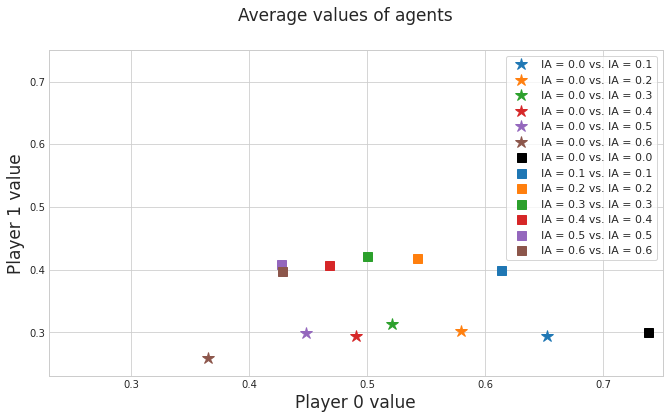

In [20]:
('default_vs_default', 'custom_vs_custom_1'),  # display 1:7
('custom_vs_custom_1', 'custom_vs_custom_2'),  # display 7:14

# plt.switch_backend("agg")
plt.style.use("seaborn-whitegrid")
COLORS = [None,] + list(mcolors.TABLEAU_COLORS)[:6] + ['black',] + list(mcolors.TABLEAU_COLORS)[:6]
RANDOM_MARKERS = [None, "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+"]
marker_list = [None,] + ['*',]*6 + ['s',]*7

plt.figure(figsize=(11, 6))
# plt.figure(figsize=(8, 5))
# for i in range(len(x)):
for i in range(1, 14):
    if i >= 7:
        label = f'IA = {param_val[i]:.1f} vs. IA = {param_val[i]:.1f}'
    else:
        label = f'IA = 0.0 vs. IA = {param_val[i]:.1f}'
    color_list = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',   '#000000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',]
#     marker_list = ['<', '>', 'X', '*', 'P', 's',   'd', '<', '>', 'X', '*', 'P', 's']
    s = 80 if cross_play[i] else 300
    plt.plot(
        x[i],
        y[i],
#         markerfacecolor="none",
        markeredgecolor=COLORS[i],
        linestyle="None",
        marker=marker_list[i],
        color=COLORS[i],
        label=label,
        markersize=9 if marker_list[i] == 's' else 13
    )
    
plt.xlabel('Player 0 value', fontsize=17)
plt.ylabel('Player 1 value', fontsize=17)
plt.xlim((0.23, 0.75))
plt.ylim((0.23, 0.75))
plt.suptitle(f'Average values of agents', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), numpoints=1,
    frameon=True,
    fontsize=11,)
#     fontsize="small",)
plt.show()

## Compute mean and std for barplots individually over different runs

In [21]:
# ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
# ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
# ('custom_vs_custom_1', 'custom_vs_custom_1'),  # as baseline

In [22]:
print(x[1:7], y[1:7])  # default vs custom, starts from 1

(0.651958, 0.57897437, 0.5209278, 0.4904595, 0.44816065, 0.3652433) (0.2946116, 0.30257654, 0.31327945, 0.29468426, 0.29970247, 0.25992543)


In [23]:
print(x[7:14], y[7:14])  # custom vs custom, starts from 0

(0.7376215, 0.6129167, 0.54170287, 0.4994951, 0.46781248, 0.4270572, 0.42730743) (0.30001095, 0.39960298, 0.41811663, 0.42247146, 0.40760374, 0.40898776, 0.3982173)


In [24]:
run_vals = []
for run_i in range(5):
    all_vals = []
    for eval_regime_name, eval_regime_list in [
        ('placeholder_name',
            (
    #            ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
               ('default_vs_default', 'custom_vs_custom_1'),   # 2.2

               ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
               ('custom_vs_custom_1', 'custom_vs_custom_1'),  # as baseline
            ),
        ),
    ]:
        for xlabel, xarray, yarray in [
            ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
        ]:
            for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
                for i, array_pos in enumerate(yarray):
#                     cross_play = None

#                     vals = np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player0_share_of_max'])
#                     x = vals.mean()
#                     x_std = vals.std()
#                     vals = np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player1_share_of_max'])
#                     y = vals.mean()
#                     y_std = vals.std()
#                     all_vals.append((x, y, x_std, y_std, xarray[i], binding, cross_play))
                    
                    all_vals.append((np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player0_share_of_max']),
                                     np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player1_share_of_max'])))

    run_vals.append(all_vals)

In [26]:
run_vals = np.array(run_vals)

In [27]:
run_vals.shape

(5, 21, 2, 16384)

### Compute distances to Pareto frontier

In [28]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(run_vals[:, 1:7, :, :] - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.5413546540078692 0.000421622773273149


In [29]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(run_vals[:, 8:14, :, :] - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.41491568672316304 0.00041458697640817615


In [30]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(np.concatenate([run_vals[:, 1:7, :, :], run_vals[:, 8:14, :, :]], axis=1) - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.47813517036551617 0.00030245278579676293


In [31]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(run_vals[:, 15:21, :, :] - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.4123239246353045 0.0004092889188903068


### Compute barplot values

different welfare

In [34]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    cur_array = (run_vals[:, 1:7, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 1:7, 0, :] - run_vals[:, 1:7, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.61750597 0.0006541818492971735


same welfare

In [35]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    cur_array = (run_vals[:, 8:14, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 8:14, 0, :] - run_vals[:, 8:14, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.7032698 0.0005697757364445937


In [36]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    cur_array = (run_vals[:, 15:21, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 15:21, 0, :] - run_vals[:, 15:21, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.7092597 0.0005610570831738187


In [37]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    a = np.concatenate([run_vals[:, 1:7, :, :], run_vals[:, 8:14, :, :]])
    cur_array = (a.sum(axis=2) - ia_val * np.abs(a[:, :, 0, :] - a[:, :, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.66038793 0.00043591299027194013
